In [134]:
# import tools
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
from datetime import datetime
import statsmodels.api as sm
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf

In [135]:
_16_to_19_monthly_sale=pd.read_csv('monthly_sales.csv')
_16_Jan_daily_sale=pd.read_csv('daily_sales.csv')
_16_to_19_monthly_sale['Date']=pd.to_datetime(_16_to_19_monthly_sale['Month, Year'],format='%b-%y')
_16_to_19_monthly_sale['Year']=_16_to_19_monthly_sale.Date.dt.year
_16_to_19_monthly_sale['Month']=_16_to_19_monthly_sale.Date.dt.month
_16_to_19_monthly_sale.drop(['Month, Year'],axis=1,inplace=True)
#_16_to_19_monthly_sale['Date'] = _16_to_19_monthly_sale['Date'].apply(lambda x: datetime.strftime(x, "%b-%Y"))


In [136]:
HM=_16_to_19_monthly_sale.copy()
HM=HM.filter(regex='HM|Year', axis=1)
HM.groupby('Year').sum()

,HM-NE,HM-SW,HM-NW,HM-SE,HM-C
Year,,,,,
2016,15018452,15089397,14674588,14504772,14255683
2017,17741690,17420447,17131715,16864459,16612812
2018,19004783,18756738,18508629,18178265,17965178
2019,13597409,13155125,13257068,12781118,12748702


In [137]:
TS_data=_16_to_19_monthly_sale.set_index('Date').drop(['Year','Month'],axis=1).copy()
food_sales=pd.DataFrame()
food_sales['total_sales_in_million']=TS_data.sum(axis=1)/1000000
food_sales['HM_total_sales_in_million']=TS_data.filter(like='HM').sum(axis=1)/1000000
food_sales['CF_total_sales_in_million']=TS_data.filter(like='CF').sum(axis=1)/1000000
food_sales['FF_total_sales_in_million']=TS_data.filter(like='FF').sum(axis=1)/1000000
food_sales['HM_sales_percent']=food_sales.HM_total_sales_in_million/food_sales.total_sales_in_million
food_sales['CF_sales_percent']=food_sales.CF_total_sales_in_million/food_sales.total_sales_in_million
food_sales['FF_sales_percent']=food_sales.FF_total_sales_in_million/food_sales.total_sales_in_million

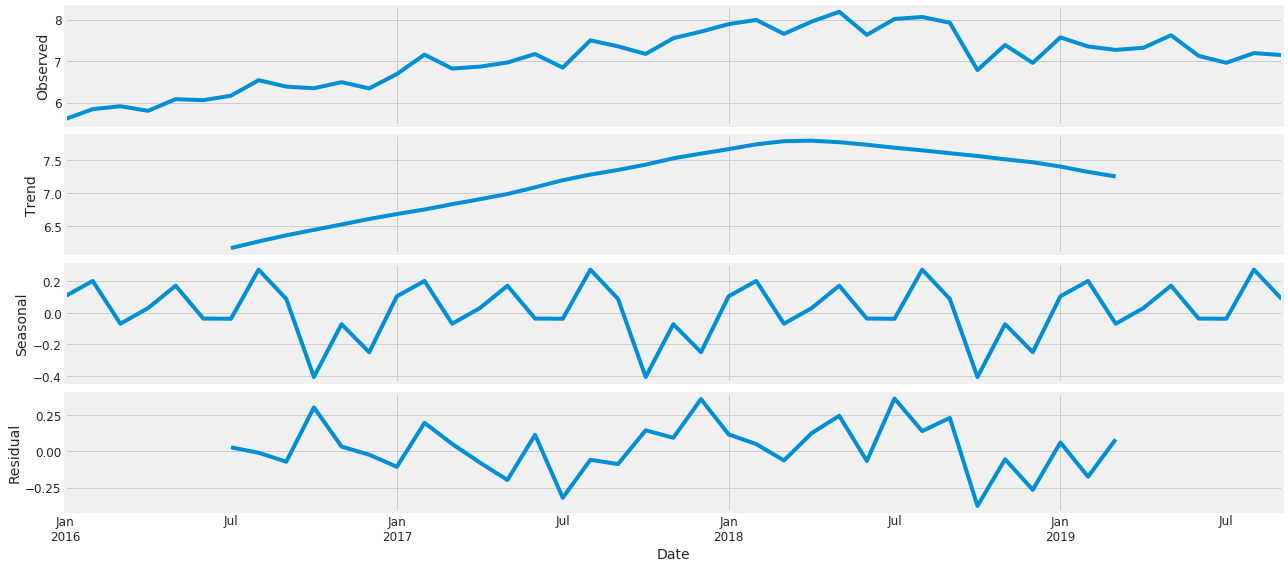

In [158]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(food_sales['HM_total_sales_in_million'], model='additive')
fig = decomposition.plot()
plt.show()

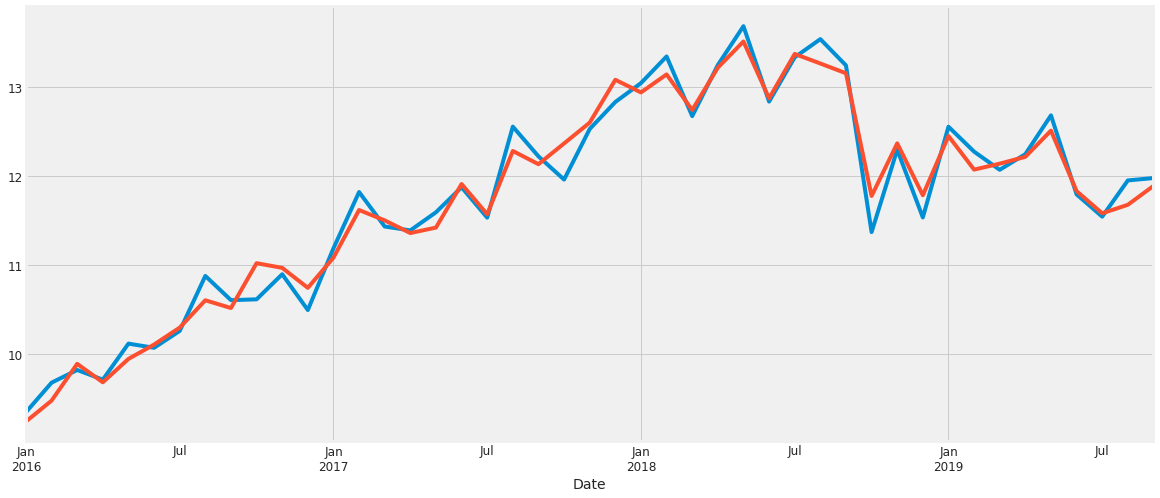

In [169]:
food_sales['total_sales_in_million_seaonality']=decomposition.seasonal
food_sales['total_sales_in_million_deseason']=food_sales.total_sales_in_million-food_sales.total_sales_in_million_seaonality
food_sales.total_sales_in_million.plot()
food_sales.total_sales_in_million_deseason.plot()


In [85]:
plot_pacf

<function statsmodels.graphics.tsaplots.plot_pacf(x, ax=None, lags=None, alpha=0.05, method='ywunbiased', use_vlines=True, title='Partial Autocorrelation', zero=True, vlines_kwargs=None, **kwargs)>

In [97]:
model= SARIMAX(np.array(food_sales['total_sales_in_million']), order=(1,1,0), seasonal_order=(1,1,0,4))

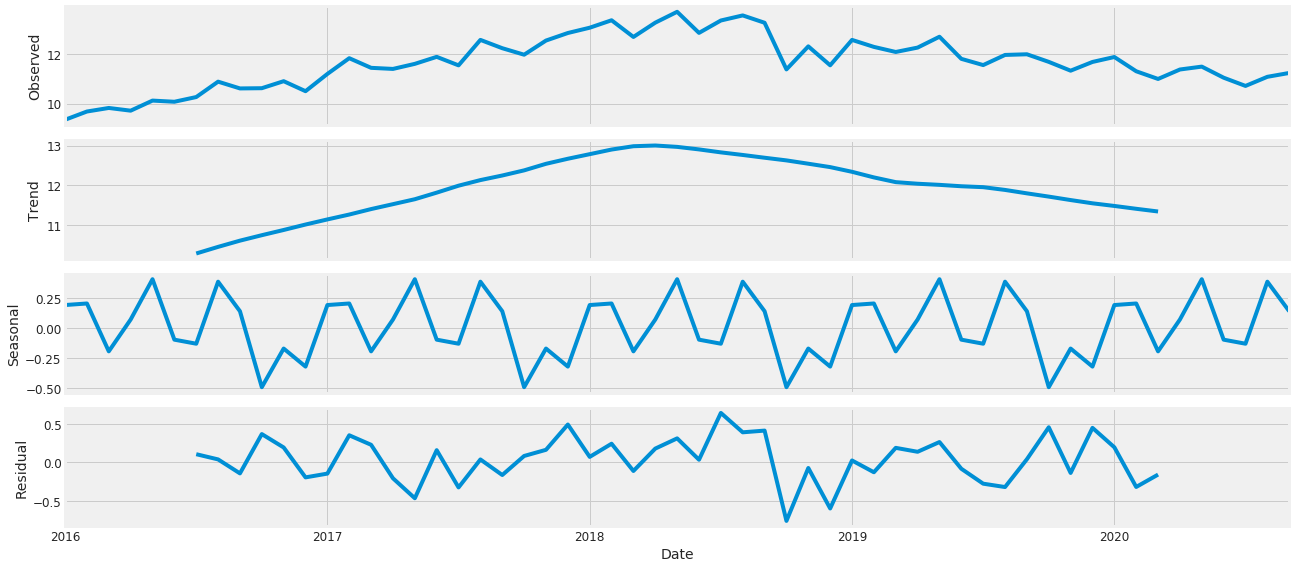

In [87]:
total_sale=food_sales.total_sales_in_million
arr=pd.Series(model.fit().forecast(12),index=['2019-10','2019-11','2019-12','2020-01','2020-02','2020-03',
                                              '2020-04','2020-05','2020-06','2020-07','2020-08','2020-09'])
forecast_total_sales=pd.DataFrame(total_sale.append(arr),
                                  columns=['total_sales_in_million']).reset_index().rename(columns={'index':'Year-Month'})
forecast_total_sales['Year-Month']=forecast_total_sales['Year-Month'].apply(lambda x: datetime.strftime(x, "%b-%Y"))
forecast_total_sales['Date'] = pd.to_datetime(forecast_total_sales['Year-Month'])
forecast_total_sales=forecast_total_sales.set_index('Year-Month',drop=True)
forecast_total_sales=forecast_total_sales.set_index('Date',drop=True)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(forecast_total_sales['total_sales_in_million'], model='additive')
fig = decomposition.plot()
plt.show()

In [104]:
dic={}
for i in ['HM_total_sales_in_million','CF_total_sales_in_million','FF_total_sales_in_million']:
    model= SARIMAX(np.array(food_sales[i]), order=(1,1,0), seasonal_order=(1,1,0,4))
    arr=model.fit().forecast(12)
    dic[i]=arr
dic['index']=['2019-10','2019-11','2019-12','2020-01','2020-02','2020-03',
                                              '2020-04','2020-05','2020-06','2020-07','2020-08','2020-09']

In [132]:
forecast_food_sales=pd.DataFrame.from_dict(dic).set_index('index',drop=True)
forecast_food_sales=pd.concat([food_sales[['HM_total_sales_in_million','CF_total_sales_in_million','FF_total_sales_in_million']],forecast_food_sales])
forecast_food_sales=forecast_food_sales.reset_index().rename(columns={'index':'Year-Month'})
forecast_food_sales['Year-Month']=forecast_food_sales['Year-Month'].apply(lambda x: datetime.strftime(x, "%b-%Y"))
forecast_food_sales['Date'] = pd.to_datetime(forecast_food_sales['Year-Month'])
forecast_food_sales=forecast_food_sales.set_index('Year-Month',drop=True)
forecast_food_sales=forecast_food_sales.set_index('Date',drop=True)
forecast_food_sales

,HM_total_sales_in_million,CF_total_sales_in_million,FF_total_sales_in_million
Date,,,
2016-01-01,5.598648,2.352671,1.399660
2016-02-01,5.840210,2.394392,1.448157
2016-03-01,5.909899,2.461847,1.453511
2016-04-01,5.799715,2.455722,1.461148
2016-05-01,6.080407,2.533501,1.507504
2016-06-01,6.056108,2.504226,1.514266
2016-07-01,6.163373,2.547327,1.553107
2016-08-01,6.537463,2.723694,1.620900
2016-09-01,6.382884,2.617860,1.609076


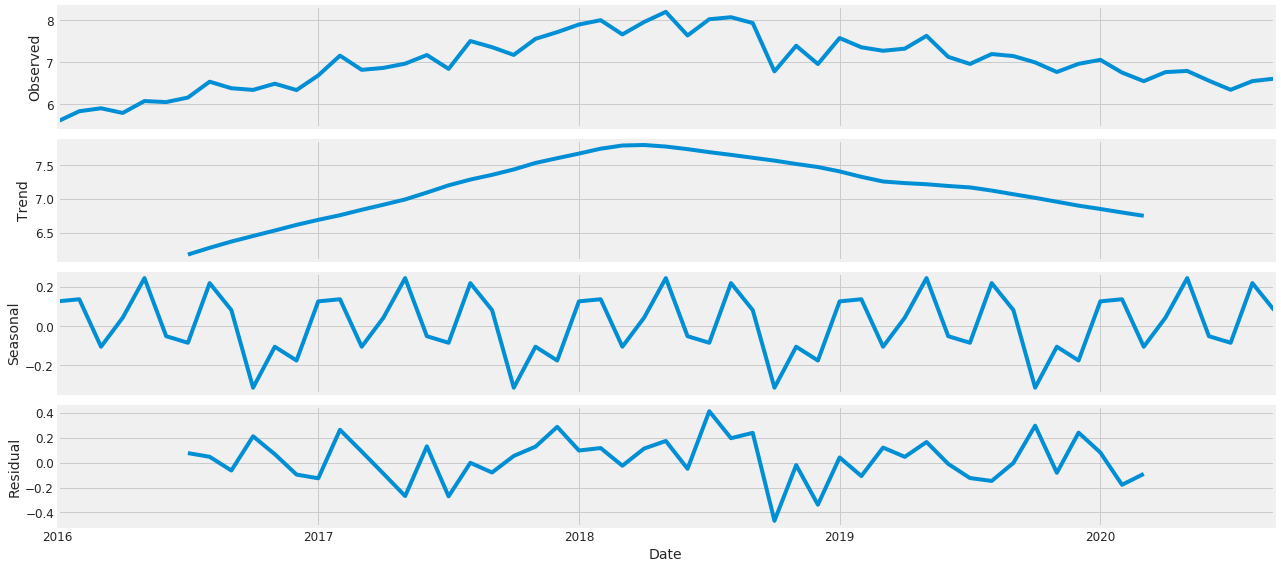

In [133]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(forecast_food_sales['HM_total_sales_in_million'], model='additive')
fig = decomposition.plot()
plt.show()

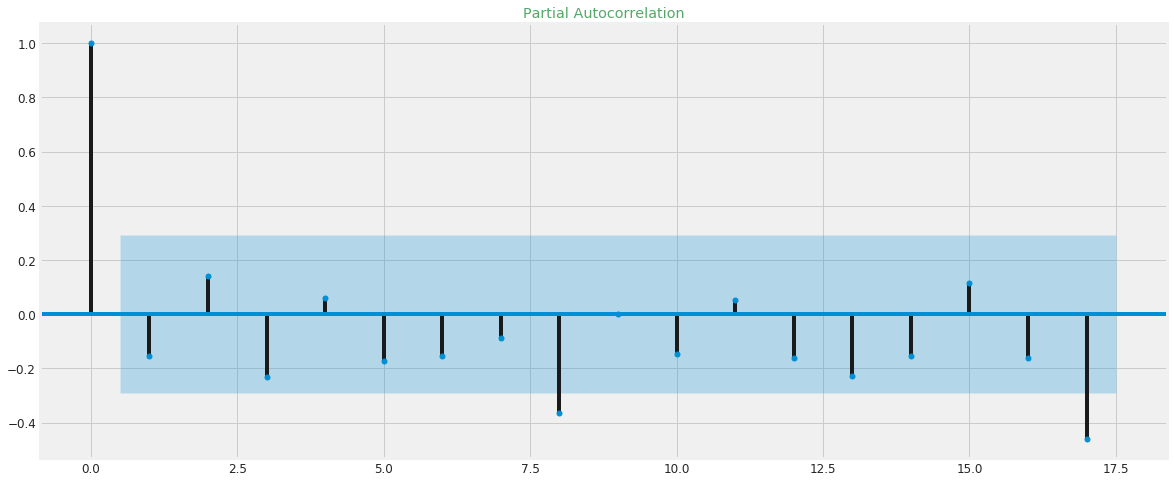

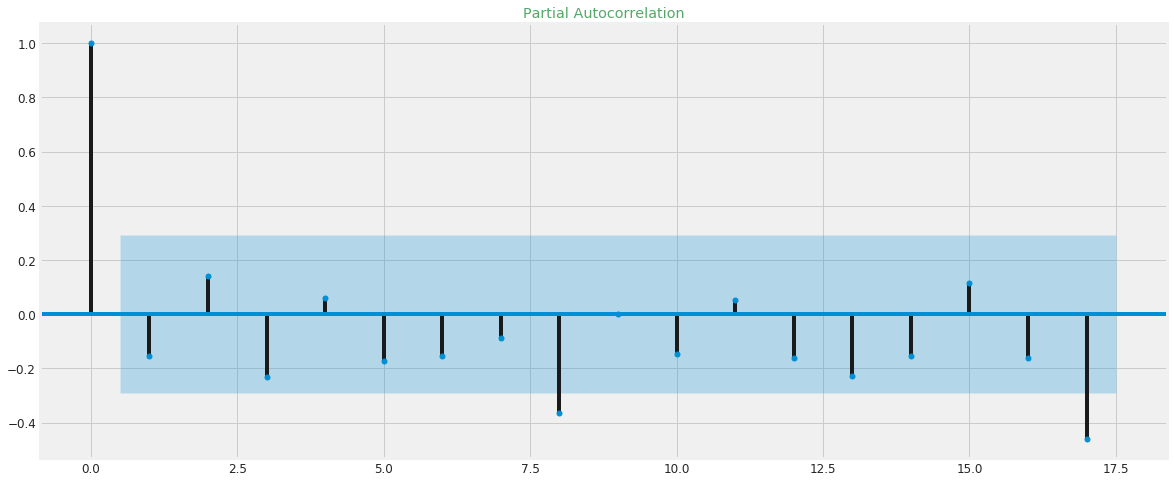

In [93]:
plot_pacf(food_sales['HM_sales_percent'])

In [177]:
region_sales=pd.DataFrame()
region_sales['NE_total_sales_in_million']=TS_data.filter(like='-NE').sum(axis=1)/1000000
region_sales['SW_total_sales_in_million']=TS_data.filter(like='-SW').sum(axis=1)/1000000
region_sales['NW_total_sales_in_million']=TS_data.filter(like='-NW').sum(axis=1)/1000000
region_sales['SE_total_sales_in_million']=TS_data.filter(like='-SE').sum(axis=1)/1000000
region_sales['C_total_sales_in_million']=TS_data.filter(like='-C').sum(axis=1)/1000000
region_sales.to_csv('region_sales.csv')

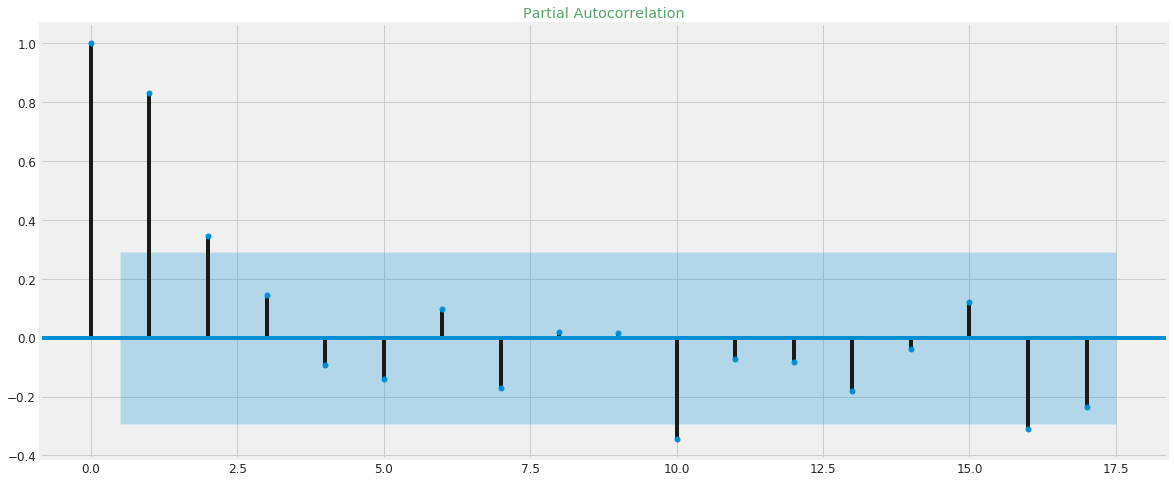

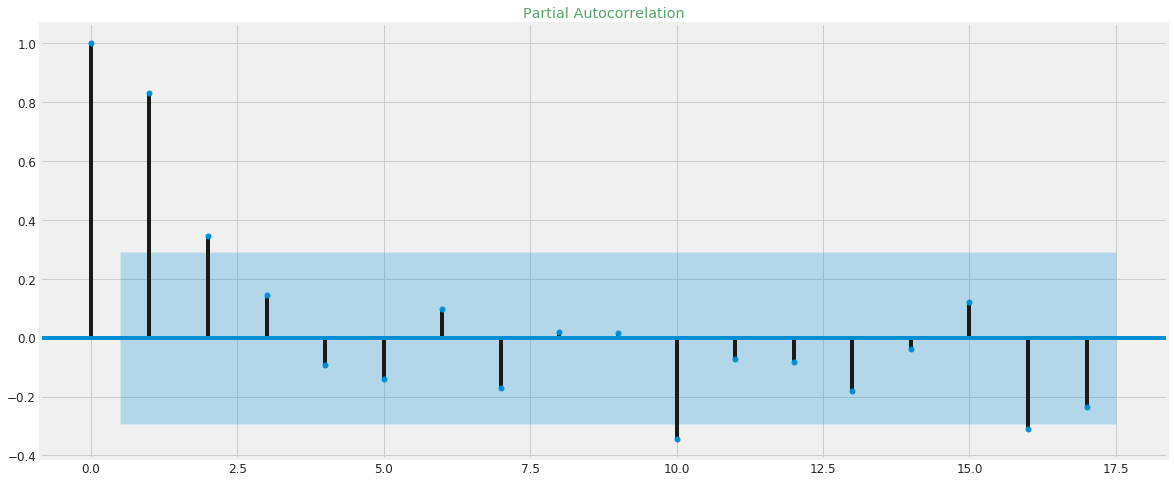

In [90]:
plot_pacf(region_sales['NE_total_sales_in_million'])

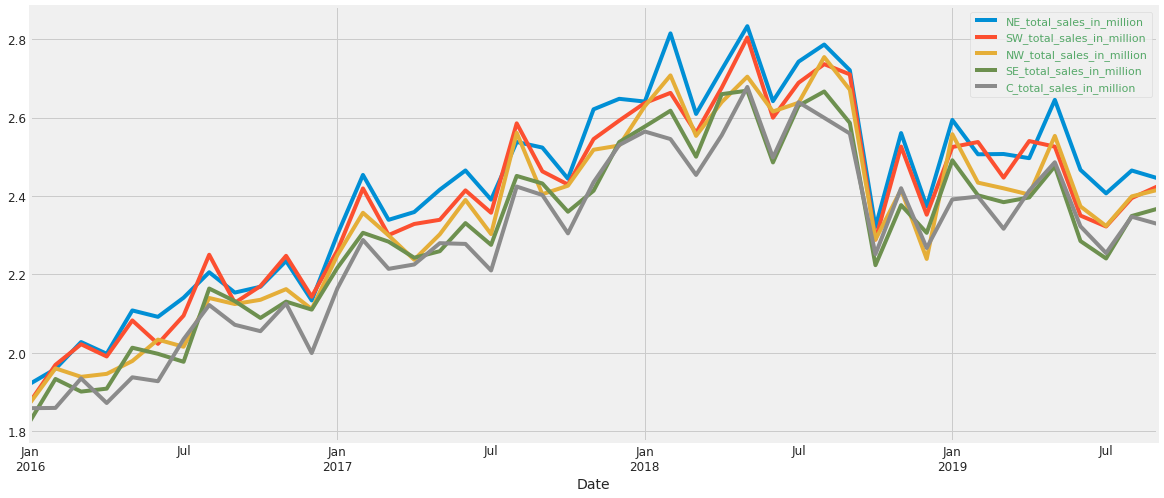

In [175]:
region_sales.plot()